<a href="https://colab.research.google.com/github/demf/proyecto-titulo/blob/main/demo_traffic_Santiago_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demostración de Modelos de Predicción de Tráfico

## Este notebook demuestra el funcionamiento de varios modelos de predicción de tráfico:

### 1. STGCN (Spatio-Temporal Graph Convolutional Network)
### 2. T-GCN (Temporal-Graph Convolutional Network / GCN-LSTM)
### 3. ConvLSTM (Convolutional LSTM)
   - 16-2D variant
   - 8-1D variant
### 4. GRU (Gated Recurrent Unit)
### 5. Linear Model
### 6. LSTM (Long Short-Term Memory)
   - 2 layers, 8 units
   - 3 layers, 8 units
   - Single layer, 8 units
### 7. MLP (Multi-Layer Perceptron)

## Paso 1: Configuración del entorno
En este paso, instalaremos todas las dependencias necesarias y configuraremos nuestro entorno de trabajo.



In [ ]:
%%capture
# Instalamos las dependencias necesarias
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121
!pip install torch-geometric==2.4.0
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.2+cu121.html
!pip install torch-geometric-temporal
!pip install tensorflow==2.11.0

## Paso 2: Clonar el repositorio (modelos y datos)


In [ ]:
!git clone https://github.com/demf/proyecto-titulo.git
%cd proyecto-titulo

Cloning into 'proyecto-titulo'...
remote: Enumerating objects: 715, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 715 (delta 6), reused 31 (delta 6), pack-reused 684 (from 1)
Receiving objects: 100% (715/715), 311.51 MiB | 11.94 MiB/s, done.
Resolving deltas: 100% (239/239), done.
Updating files: 100% (535/535), done.
/content/proyecto-titulo


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
from torch_geometric_temporal.nn import STConv
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from stellargraph.layer import GCN_LSTM

# Paso 3: Definicion de modelos, manejo de datos y evaluacion de modelos.

## El modelo STGCN se obtuvo del siguiente [articulo](https://medium.com/data-reply-it-datatech/spatio-temporal-forecasting-using-temporal-graph-neural-networks-f27a8b326e5c)

In [ ]:
# Definición de las clases necesarias
class FullyConnLayer(nn.Module):
    def __init__(self, c):
        super(FullyConnLayer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class OutputLayer(nn.Module):
    def __init__(self, c, T, n):
        super(OutputLayer, self).__init__()
        self.tconv1 = nn.Conv2d(c, c, (T, 1), 1, dilation=1, padding=(0, 0))
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = nn.Conv2d(c, c, (1, 1), 1, dilation=1, padding=(0, 0))
        self.fc = FullyConnLayer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)

class TrafficModel(torch.nn.Module):
    def __init__(self, device, num_nodes, channel_size_list, num_layers, kernel_size, K, window_size, normalization='sym', bias=True):
        super(TrafficModel, self).__init__()
        self.layers = nn.ModuleList([])
        for l in range(num_layers):
            input_size, hidden_size, output_size = channel_size_list[l][0], channel_size_list[l][1], channel_size_list[l][2]
            self.layers.append(STConv(num_nodes, input_size, hidden_size, output_size, kernel_size, K, normalization, bias))
        self.layers.append(OutputLayer(channel_size_list[-1][-1], window_size - 2 * num_layers * (kernel_size - 1), num_nodes))
        for layer in self.layers:
            layer = layer.to(device)

    def forward(self, x, edge_index, edge_weight):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index, edge_weight)
        out_layer = self.layers[-1]
        x = x.permute(0, 3, 1, 2)
        x = out_layer(x)
        return x

def data_transform(data, n_his, n_pred, device):
    num_nodes = data.shape[1]
    num_obs = len(data) - n_his - n_pred
    x = np.zeros([num_obs, n_his, num_nodes, 1])
    y = np.zeros([num_obs, num_nodes])

    for i in range(num_obs):
        head = i
        tail = i + n_his
        x[i, :, :, :] = data[head:tail].reshape(n_his, num_nodes, 1)
        y[i] = data[tail + n_pred - 1]

    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)


## Manejo de datos para modelos generales

In [ ]:
class WindowGenerator:
    def __init__(self, input_width, label_width, shift, batch_size=None,
                 train_df=None, val_df=None, test_df=None,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        #store scale_data
        self.train_scale = self.scale_data(train_df)
        self.val_scale = self.scale_data(val_df)
        self.test_scale = self.scale_data(test_df)
        # Work out the label column indices.
        self.batch_size = batch_size if batch_size is not None else 64
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(self.train_scale.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        #store original data slit
        self.val_window = self.window_unscale(self.make_dataset(self.val_scale))
        self.test_window = self.window_unscale(self.make_dataset(self.test_scale))

    @property
    def train(self):
        return self.make_dataset(self.train_scale)

    @property
    def val(self):
        return self.make_dataset(self.val_scale)

    @property
    def test(self):
        return self.make_dataset(self.test_scale)

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size,)
        ds = ds.map(self.split_window)
        return ds

    def scale_data(self, data):
        scale_data = (data - self.min_speed) / (self.max_speed - self.min_speed)
        return scale_data

    def rescale_data(self, data):
        return data * self.max_speed

    def window_unscale(self, data):
        data_window = np.concatenate([labels.numpy() for _, labels in data.take(-1)], axis=0)
        data_window = data_window[:, -OUT_STEPS:, :]
        return data_window * self.max_speed

class Dataset(WindowGenerator):
    def __init__(self, data_path, timestamp_path, input_width, label_width, shift, batch_size=None, label_columns=None):
        self.data_path = data_path
        self.timestamp_path = timestamp_path
        self.dataset, self.time_index = self.data_load()
        self.train_df, self.val_df, self.test_df = self.split_data()
        self.num_features = self.dataset.shape[1]
        self.max_speed = self.train_df.max().max()
        self.min_speed = self.train_df.min().min()
        super().__init__(
            input_width=input_width,
            label_width=label_width,
            shift=shift,
            batch_size=batch_size,
            train_df=self.train_df,
            val_df=self.val_df,
            test_df=self.test_df,
            label_columns=label_columns
        )

    def data_load(self):
        dataset = pd.read_csv(self.data_path, index_col=False, header=None)
        timestamps = pd.read_csv(self.timestamp_path, index_col=False, header=None)
        time_index = pd.to_datetime(timestamps[0])
        return dataset, time_index

    def split_data(self):
        n = len(self.dataset)
        train_df = self.dataset.iloc[0:int(n*0.7)]
        val_df = self.dataset.iloc[int(n*0.7):int(n*0.85)]
        test_df = self.dataset.iloc[int(n*0.85):]

        # Asignar los índices de tiempo correspondientes
        train_df.index = self.time_index[0:int(n*0.7)]
        val_df.index = self.time_index[int(n*0.7):int(n*0.85)]
        test_df.index = self.time_index[int(n*0.85):]

        return train_df, val_df, test_df

## Evaluacion de modelos

In [ ]:
def evaluate_stgcn(grid_size, temp):
    save_path = f'modelos/{temp}min/{grid_size}_STGCN/'
    model_save_path = save_path + 'model.pt'
    V, W, timestamps = load_data(temp, grid_size)

    num_samples, num_nodes = V.shape
    train_prop, val_prop = 0.7, 0.15
    len_train = int(num_samples * train_prop)
    len_val = int(num_samples * val_prop)

    train = V[:len_train]
    test = V[len_train + len_val:]

    max_speed = train.max()
    min_speed = train.min()

    test = np.nan_to_num((test - min_speed) / (max_speed - min_speed))

    n_his, n_pred = 20, 1
    batch_size = 50
    channels = np.array([[1, 16, 64], [64, 16, 64]])
    num_layers, kernel_size, K = 2, 3, 3

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x_test, y_test = data_transform(test, n_his, n_pred, device)
    test_data = torch.utils.data.TensorDataset(x_test, y_test)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size)

    G = sp.coo_matrix(W)
    edge_index = torch.tensor(np.array([G.row, G.col]), dtype=torch.int64).to(device)
    edge_weight = torch.tensor(G.data).float().to(device)

    model = TrafficModel(device, num_nodes, channels, num_layers, kernel_size, K, n_his).to(device)
    model.load_state_dict(torch.load(model_save_path, map_location=device))
    model.eval()

    y_pred_list, y_true_list = [], []

    with torch.no_grad():
        for x, y in test_iter:
            y_pred = model(x.to(device), edge_index, edge_weight).view(len(x), -1)
            y_pred_list.append(y_pred.cpu().numpy())
            y_true_list.append(y.cpu().numpy())

    y_pred = np.concatenate(y_pred_list, axis=0)
    y_true = np.concatenate(y_true_list, axis=0)

    y_pred = y_pred * (max_speed - min_speed) + min_speed
    y_true = y_true * (max_speed - min_speed) + min_speed

    metrics = calculate_metrics(y_true.flatten(), y_pred.flatten())

    return metrics

def evaluate_tgcn(grid_size, temp):
    dataset, abj_matrix, time_index = load_data(temp, grid_size)

    # División de datos
    n = len(dataset)
    train_data = dataset[:int(n*0.7)]
    val_data = dataset[int(n*0.7):int(n*0.85)]
    test_data = dataset[int(n*0.85):]

    # Escalado de datos
    max_speed = np.max(train_data)
    min_speed = np.min(train_data)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)

    # Preparación de secuencias
    seq_len = 20
    pre_len = 1
    testX, testY = sequence_data_preparation(seq_len, pre_len, test_scaled)

    # Cargar modelo
    model_name = 'GCN-LSTM-'
    key = f'{model_name}_{str(seq_len)}_t'
    model_load_path = f'modelos/{temp}min/{grid_size}_{key}'

    model = tf.keras.models.load_model(model_load_path)

    # Predicciones
    test_predictions = model.predict(testX)
    test_predictions_rescaled = test_predictions * (max_speed - min_speed) + min_speed
    testY_rescaled = testY * (max_speed - min_speed) + min_speed

    # Calcular métricas
    metrics = calculate_metrics(testY_rescaled.flatten(), test_predictions_rescaled.flatten())
    return metrics

def sequence_data_preparation(seq_len, pre_len, data):
    n = data.shape[0]
    X, Y = [], []
    for i in range(n - seq_len - pre_len + 1):
        X.append(data[i:i+seq_len].T)
        Y.append(data[i+seq_len+pre_len-1])
    return np.array(X), np.array(Y)

def evaluate_general_model(grid_size, temp, model_name):
    data_path = f'datos/{temp}min/RED_V_{grid_size}.csv'
    timestamp_path = f'datos/{temp}min/timestamps_{grid_size}.csv'

    ds = Dataset(data_path, timestamp_path, input_width=time_step, label_width=OUT_STEPS, shift=OUT_STEPS, batch_size=batch_size)

    model_save_path = f'modelos/{temp}min/{grid_size}_{model_name}_{time_step}_t'

    # Cargar el modelo usando tf.saved_model.load
    model = tf.saved_model.load(model_save_path)

    # Realizar predicciones
    test_predictions = model(next(iter(ds.test))[0])
    if isinstance(test_predictions, dict):
        test_predictions = next(iter(test_predictions.values()))

    test_predictions_rescaled = ds.rescale_data(test_predictions.numpy())
    y_true = ds.test_window.astype(float)

    # Asegurarse de que las dimensiones coincidan
    min_len = min(y_true.shape[0], test_predictions_rescaled.shape[0])
    y_true = y_true[:min_len]
    test_predictions_rescaled = test_predictions_rescaled[:min_len]

    if len(y_true.shape) == 3:
        y_true = y_true.reshape(-1, y_true.shape[-1])
    if len(test_predictions_rescaled.shape) == 3:
        test_predictions_rescaled = test_predictions_rescaled.reshape(-1, test_predictions_rescaled.shape[-1])

    metrics = calculate_metrics(y_true.flatten(), test_predictions_rescaled.flatten())

    return metrics

# Paso 4: Ejecutar modelos y metricas

Iniciando evaluación de modelos...

Evaluando modelos para temporalidad 10 y tamaño de grilla 51
Evaluando GCN-LSTM-...
328/328 [==============================] - 19s 53ms/step
Evaluando STGCN...
Evaluando convlstm_16-2D...
Evaluando convlstm_8-1D...
Evaluando gru_8...
Evaluando linear...
Evaluando lstm_2_8...
Evaluando lstm_3_8...
Evaluando lstm_8...
Evaluando mlp...

Evaluando modelos para temporalidad 10 y tamaño de grilla 65
Evaluando GCN-LSTM-...
328/328 [==============================] - 13s 36ms/step
Evaluando STGCN...
Evaluando convlstm_16-2D...
Evaluando convlstm_8-1D...
Evaluando gru_8...
Evaluando linear...
Evaluando lstm_2_8...
Evaluando lstm_3_8...
Evaluando lstm_8...
Evaluando mlp...

Evaluando modelos para temporalidad 10 y tamaño de grilla 75
Evaluando GCN-LSTM-...
328/328 [==============================] - 13s 38ms/step
Evaluando STGCN...
Evaluando convlstm_16-2D...
Evaluando convlstm_8-1D...
Evaluando gru_8...
Evaluando linear...
Evaluando lstm_2_8...
Evaluando lstm_3

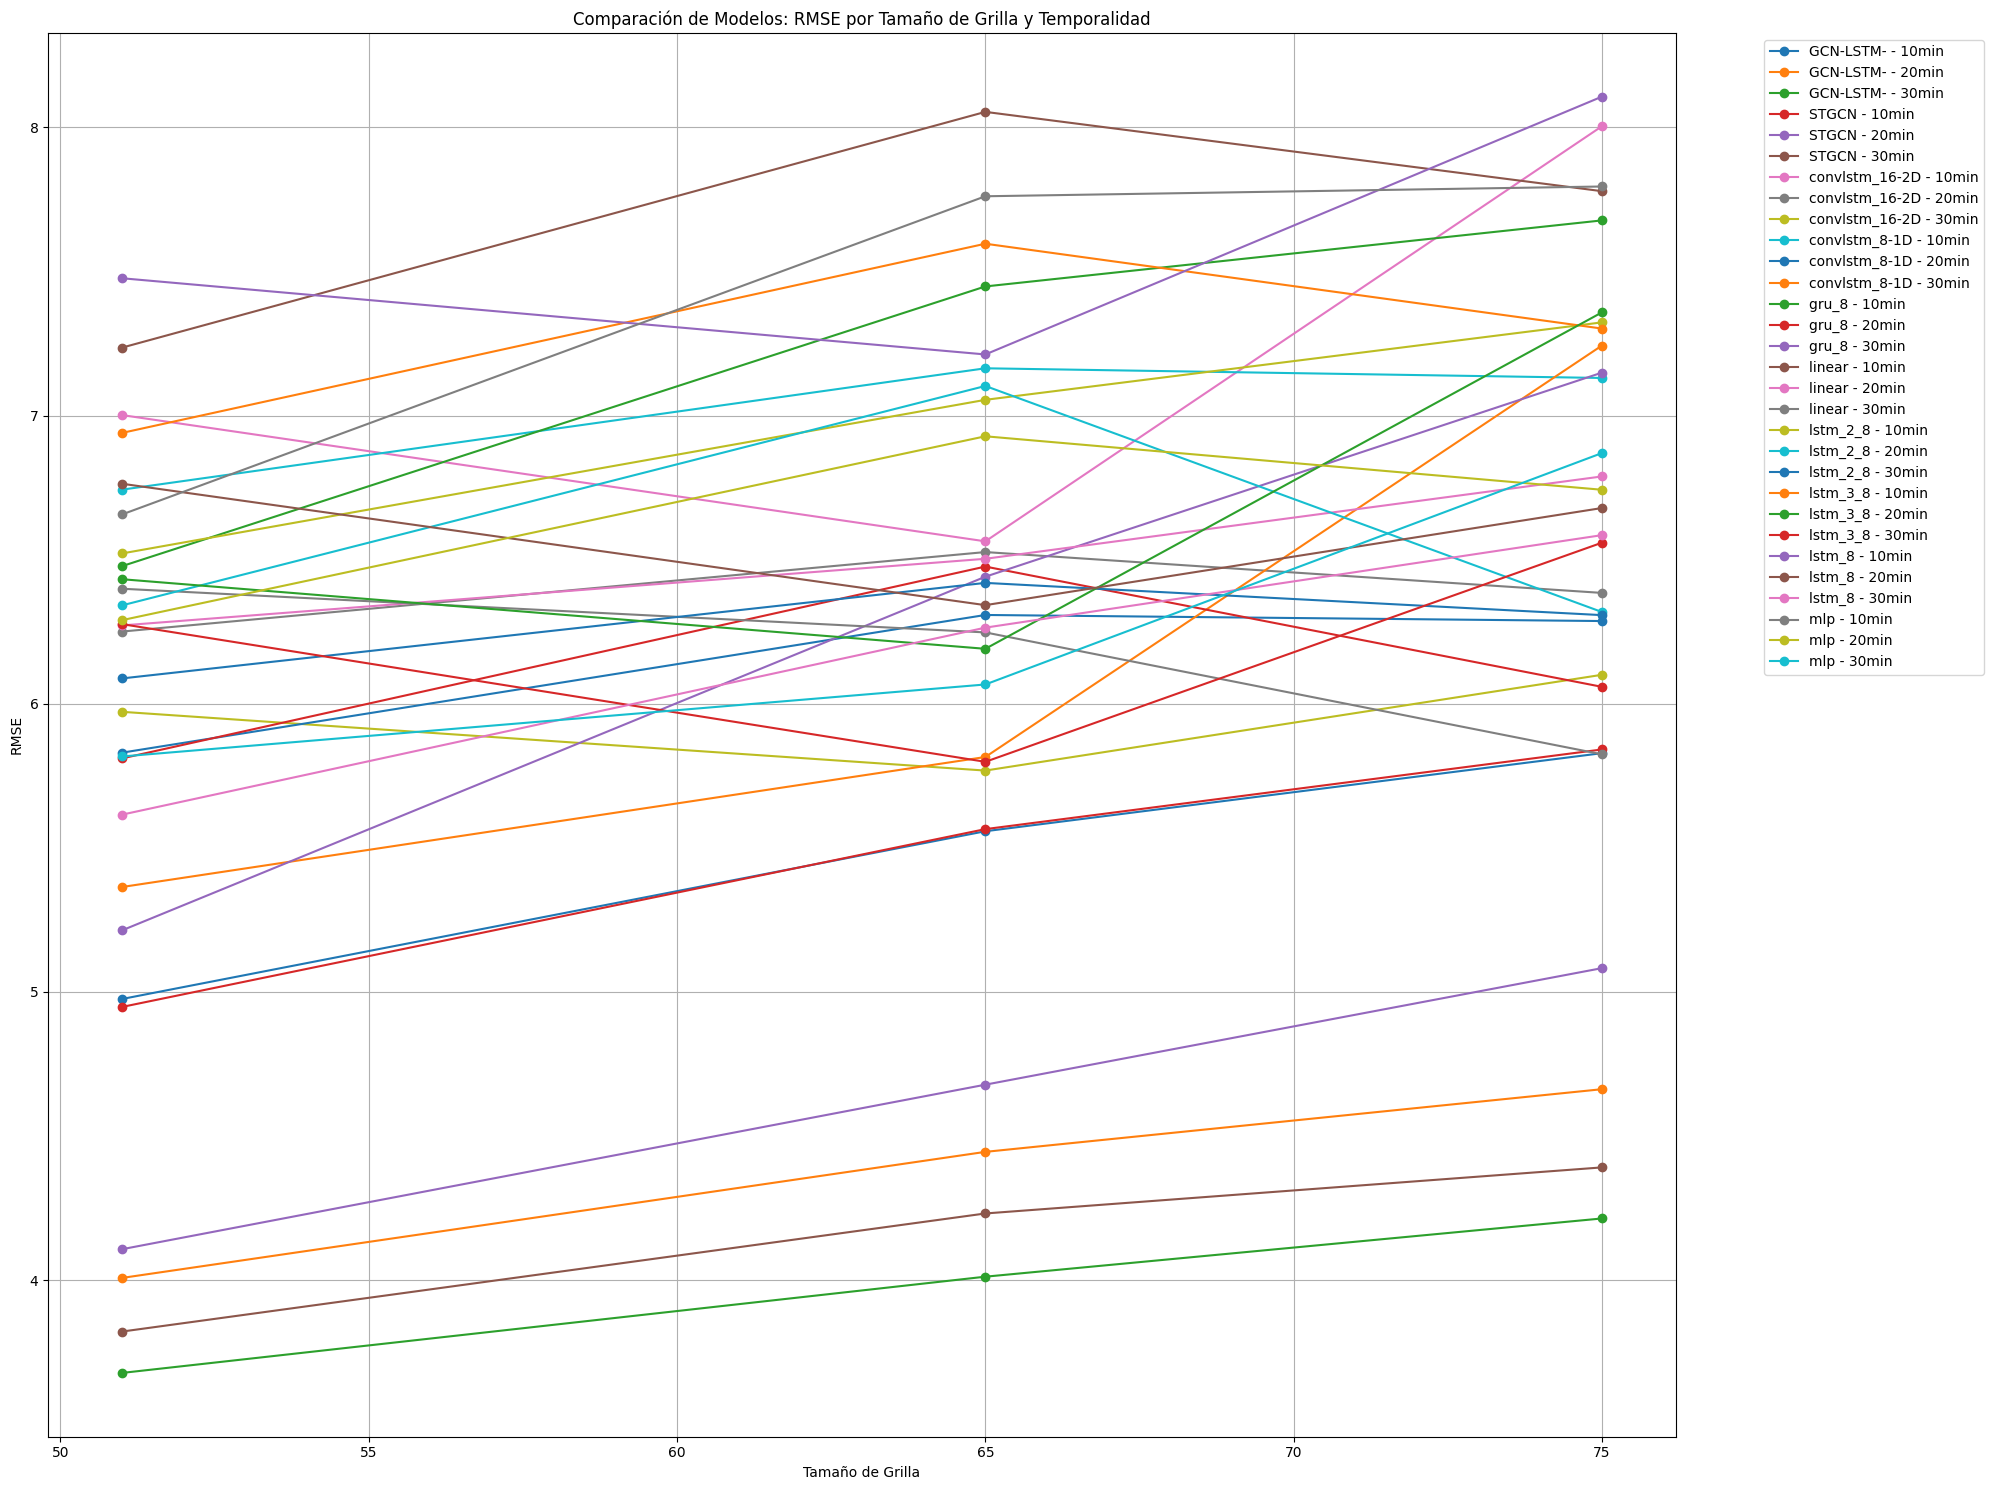


Resultados guardados en 'resultados_evaluacion.csv'


In [ ]:
# Configuración inicial
temps = [10, 20, 30]
grids = [51, 65, 75]
time_step = 20
OUT_STEPS = 1
batch_size = 32

# Lista actualizada de todos los modelos
models = [
    'GCN-LSTM-', 'STGCN',
    'convlstm_16-2D', 'convlstm_8-1D',
    'gru_8', 'linear',
    'lstm_2_8', 'lstm_3_8', 'lstm_8',
    'mlp'
]

# Funciones de métricas
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_metrics(y_true, y_pred):
    return {'RMSE': rmse(y_true, y_pred), 'MAE': mae(y_true, y_pred)}

# Funciones de carga y evaluación
def load_data(temp, num_grid):
    data_path = f'datos/{temp}min/'
    timeseries = pd.read_csv(f"{data_path}RED_V_{num_grid}.csv", header=None, index_col=False).to_numpy()
    adj_matrix = pd.read_csv(f"datos/matriz_aby/RED_W_{num_grid}.csv", header=None, index_col=False).to_numpy()
    timestamps = pd.read_csv(f"{data_path}timestamps_{num_grid}.csv", header=None, index_col=False).squeeze()
    timestamps = pd.to_datetime(timestamps)
    return timeseries, adj_matrix, timestamps

def evaluate_model(grid_size, temp, model_name):
    if model_name == 'STGCN':
        return evaluate_stgcn(grid_size, temp)
    elif model_name == 'GCN-LSTM-':
        return evaluate_tgcn(grid_size, temp)
    else:
        return evaluate_general_model(grid_size, temp, model_name)

def run_evaluation():
    results = []
    for temp in temps:
        for grid_size in grids:
            print(f"\nEvaluando modelos para temporalidad {temp} y tamaño de grilla {grid_size}")

            for model_name in models:
                print(f"Evaluando {model_name}...")
                metrics = evaluate_model(grid_size, temp, model_name)
                results.append({
                    'Temporalidad': temp,
                    'Grillas': grid_size,
                    'Modelo': model_name,
                    'RMSE': metrics['RMSE'],
                    'MAE': metrics['MAE']
                })

    return pd.DataFrame(results)

def main():
    print("Iniciando evaluación de modelos...")
    results = run_evaluation()

    print("\nResultados generales:")
    print(results)

    # Visualización
    plt.figure(figsize=(20, 15))
    for model in models:
        for temp in temps:
            model_temp_data = results[(results['Modelo'] == model) & (results['Temporalidad'] == temp)]
            plt.plot(model_temp_data['Grillas'], model_temp_data['RMSE'], marker='o', label=f'{model} - {temp}min')

    plt.xlabel('Tamaño de Grilla')
    plt.ylabel('RMSE')
    plt.title('Comparación de Modelos: RMSE por Tamaño de Grilla y Temporalidad')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Guardar resultados
    results.to_csv('resultados_evaluacion.csv', index=False)
    print("\nResultados guardados en 'resultados_evaluacion.csv'")

if __name__ == "__main__":
    main()